# **IEOR 4650  Business Analytics (Fall 2019)**

**Homework 3 [Total points: 60]**

** Due: 11:59 PM, October *****

This second homework consists of Python programming practices and the applications to Poisson regression. 

The steps to finish in the homework:

*   Step 1: Make a copy of the file to your LionDrive.
*   Step 2: Work with the copy (an ipynb file).
*    <font color='red'>**Step 3: Rename the copy to your_uni_hw3.ipynb (For example: yd4501_hw3.ipynb).**</font>  
*   Step 4: Submit the copy on CourseWorks.

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)


**All the questions in this homework requires coding**

In [0]:
#This imports all the packages you need for the homework
#Please run this first


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#import modules

import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import sklearn 
import scipy.special as spsp
from scipy.optimize import minimize
import scipy.stats as spst

#Exercise 1 [Total: 23 points]


##Setting
In this example, we take a closer look at the data we used for Poisson regression. 

This data measures the number of ad exposures each customer got **within 1 day**. 


(1) In the class, we checked the model fitting based on how closely the predicted numbers of customers having different number of exposures match with the samples we actually observe. In this exercise, we will explore how to apply cross-validation to Poisson regression.

(2) We are interested in using this dataset to make meaningful business recommendation.

In [0]:
#Load the dataset
link="https://drive.google.com/open?id=1pjdoOKuczV8Zc6Zw8-yUh6q2tqogN-xt"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Exposure.csv')  
Ad = pd.read_csv('Exposure.csv')
Ad.head(5)



,Cookie_ID,Exposures
0,1,0
1,2,0
2,3,3
3,4,49
4,5,4


## Q1 [10 points]

**[Cross validation]**

In the class, we checked the model fitting based on how closely the predicted numbers of customers having different number of exposures match with the samples we actually observe. However, we were basically doing the model selection and model fitting using the chunk of data. 

For this exercise, let's first separate the data by

* first randomize the data 
* Split our data into 3 sets. 

>> Training: The first 4000 observations

>> Validation: Observation 4001 to 4500

>> Testing: Observation 4501 to 5000.

We then test which model is the best model.

* Simple Poisson
* 2-segment Poisson 
* Zero-inflated Poisson 
* NBD (Poisson-Gamma)

For the model accuracy, let's use the joint log likelihood. Again, the higher the joint log likelihood, the better the model is. 

Based on the result, rank the model performance from the highest to the lowest.





In [0]:
#don't remove this line (otherwise, you lose 2 points)
np.random.seed(30)

#shuffle and split
Ad_shuffled=sklearn.utils.shuffle(Ad)
Ad_training=Ad_shuffled[0:4000]
Ad_validation=Ad_shuffled[4000:4500]
Ad_testing=Ad_shuffled[4500:]

Ad_training.head(4)

,Cookie_ID,Exposures
2192,2193,3
911,912,0
3061,3062,3
3382,3383,28


In [0]:
#Model1
Exposures_training=Ad_training["Exposures"].values
Exposures_validation=Ad_validation["Exposures"].values

def neg_LL(beta):
  lmbda=np.exp(beta)
  #individual log likelihood
  ind_LL=np.log(spst.poisson.pmf(Exposures_training,lmbda))
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL
#randomly select a starting point
guess=np.random.rand()
#start minimization
result1=minimize(neg_LL,guess,method="BFGS")
lmbda_hat=np.exp(result1.x)



ind_LL=np.log(spst.poisson.pmf(Exposures_validation,lmbda_hat))

#joint log likelihood
JLL1=np.sum(ind_LL)

In [0]:
#Model2
def neg_LL(betas):
  lmbda1=np.exp(betas[0])
  lmbda2=np.exp(betas[1])
  p=np.exp(betas[2])/(1+np.exp(betas[2]))
  #individual log likelihood
  ind_L1=spst.poisson.pmf(Exposures_training,lmbda1)
  ind_L2=spst.poisson.pmf(Exposures_training,lmbda2)
  ind_LL=np.log(ind_L1*p+ind_L2*(1-p))
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL
#randomly select a starting point
guess=np.random.rand(3)
#start minimization
result2=minimize(neg_LL,guess,method="BFGS")
betas=result2.x
lmbda1_hat=np.exp(betas[0])
lmbda2_hat=np.exp(betas[1])
p_hat=np.exp(betas[2])/(1+np.exp(betas[2]))

ind_L1= spst.poisson.pmf(Exposures_validation,lmbda1_hat)
ind_L2=spst.poisson.pmf(Exposures_validation,lmbda2_hat)
ind_LL=np.log(ind_L1*p_hat+ind_L2*(1-p_hat))
#joint log likelihood
JLL2=np.sum(ind_LL)

In [0]:
#Model3
def neg_LL(betas):
  lmbda1=0
  lmbda2=np.exp(betas[0])
  p=np.exp(betas[1])/(1+np.exp(betas[1]))
  #individual log likelihood
  ind_L1=spst.poisson.pmf(Exposures_training,lmbda1)
  ind_L2=spst.poisson.pmf(Exposures_training,lmbda2)
  ind_LL=np.log(ind_L1*p+ind_L2*(1-p))
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL
#randomly select a starting point
guess=np.random.rand(2)
#start minimization
result3=minimize(neg_LL,guess,method="BFGS")
betas=result3.x
lmbda1_hat=0
lmbda2_hat=np.exp(betas[0])
p_hat=np.exp(betas[1])/(1+np.exp(betas[1]))
 
ind_L1= spst.poisson.pmf(Exposures_validation,lmbda1_hat)
ind_L2=spst.poisson.pmf(Exposures_validation,lmbda2_hat)
ind_LL=np.log(ind_L1*p_hat+ind_L2*(1-p_hat))
#joint log likelihood
JLL3=np.sum(ind_LL)

In [0]:
#Model3
def neg_LL(betas,Exposures_training,Exposures_validation):
  lmbda1=0
  lmbda2=np.exp(betas[0])
  p=np.exp(betas[1])/(1+np.exp(betas[1]))
  #individual log likelihood
  ind_L1=spst.poisson.pmf(Exposures_training,lmbda1)
  ind_L2=spst.poisson.pmf(Exposures_training,lmbda2)
  ind_LL=np.log(ind_L1*p+ind_L2*(1-p))
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL
#randomly select a starting point
guess=np.random.rand(2)
#start minimization
result3=minimize(neg_LL,guess,args=(Exposures_training,Exposures_validation),method="BFGS")
betas=result3.x
lmbda1_hat=0
lmbda2_hat=np.exp(betas[0])
p_hat=np.exp(betas[1])/(1+np.exp(betas[1]))
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [0]:
#Model4
def neg_LL(betas):
  alpha=np.exp(betas[0])
  gamma=np.exp(betas[1])
  #individual log likelihood
  ind_L=spsp.gamma(gamma+Exposures_training)/spsp.gamma(gamma)/spsp.gamma(Exposures_training+1)\
  *(1/(1+alpha))**Exposures_training*(alpha/(1+alpha))**gamma
  ind_LL=np.log(ind_L)
  #joint log likelihood
  Joint_LL=np.sum(ind_LL)
  return -Joint_LL
#randomly select a starting point
guess=np.random.rand(2)
#start minimization
result4=minimize(neg_LL,guess,method="BFGS")
betas=result4.x
alpha_hat=np.exp(betas[0])
gamma_hat=np.exp(betas[1])
 
ind_L=spsp.gamma(gamma_hat+Exposures_validation)/spsp.gamma(gamma_hat)/spsp.gamma(Exposures_validation+1)\
  *(1/(1+alpha_hat))**Exposures_validation*(alpha_hat/(1+alpha_hat))**gamma_hat
ind_LL=np.log(ind_L)
#joint log likelihood
JLL4=np.sum(ind_LL)

In [0]:
print(JLL1,JLL2,JLL3,JLL4)

-2082.3649844534657 -1149.7562188731767 -1479.42543760672 -938.9661327808763


In terms of model perfoamcne, we have the following ranking from the highest to the lowest

(1) NBD
(2) 2-segment Poisson
(3) Zero-inflated Poisson
(4) One-segment Poisson

##Q2 [4 points]

Based on the model learned on the training set, report the expected number of exposures for the market using each model you tested in Q1.

In [0]:
#Model1
lmbda_hat=np.exp(result1.x)
print(lmbda_hat[0])

#Model2
betas=result2.x
lmbda1_hat=np.exp(betas[0])
lmbda2_hat=np.exp(betas[1])
p_hat=np.exp(betas[2])/(1+np.exp(betas[2]))
print(lmbda1_hat*p_hat+lmbda2_hat*(1-p_hat))
#Model3
betas=result3.x
lmbda1_hat=0
lmbda2_hat=np.exp(betas[0])
p_hat=np.exp(betas[1])/(1+np.exp(betas[1]))
print(lmbda1_hat*p_hat+lmbda2_hat*(1-p_hat))

#Model3
betas=result4.x
alpha_hat=np.exp(betas[0])
gamma_hat=np.exp(betas[1])
print(gamma_hat/alpha_hat)

##If students multipled 2.5 by the market size, that is fine. Give them full points.

2.5057499802237246
2.505750165222403
2.505749985965562
2.505750137582406


## Q3 [9 points]

Assume that we decide to stick to NBD model, we want to use this model to do something meaningful.

(1) Based on the model, how many people do you predict on the testing set to have at most 1 exposure? How does this number match with the actual observation?

(2) How many more days of exposures do we at least need to reduce this number to below 200? [You only need to consider integer days]

(3) Assume a customer had 0 exposures, visualize the posterior distribution of $\lambda$ for this customer.

(4) Assume a customer had 5 exposures, visualize the posterior distribution of $\lambda$ for this customer.



In [0]:
#observed
Ad_testing[(Ad_testing["Exposures"]==0)|(Ad_testing["Exposures"]==1)].shape[0]

328

In [0]:
#predicted
x=0
p0=spsp.gamma(gamma_hat+x)/spsp.gamma(gamma_hat)/spsp.gamma(x+1)\
  *(1/(1+alpha_hat))**x*(alpha_hat/(1+alpha_hat))**gamma_hat
x=1
p1=spsp.gamma(gamma_hat+x)/spsp.gamma(gamma_hat)/spsp.gamma(x+1)\
  *(1/(1+alpha_hat))**x*(alpha_hat/(1+alpha_hat))**gamma_hat

(p0+p1)*Ad_testing.shape[0]

336.87171582843655

In [0]:
#predicted
x=0
t=10
p0=spsp.gamma(gamma_hat+x)/spsp.gamma(gamma_hat)/spsp.gamma(x+1)\
  *(t/(t+alpha_hat))**x*(alpha_hat/(t+alpha_hat))**gamma_hat
x=1
p1=spsp.gamma(gamma_hat+x)/spsp.gamma(gamma_hat)/spsp.gamma(x+1)\
  *(t/(t+alpha_hat))**x*(alpha_hat/(t+alpha_hat))**gamma_hat

(p0+p1)*Ad_testing.shape[0]

#We need at least 9 more days

196.82576675272617

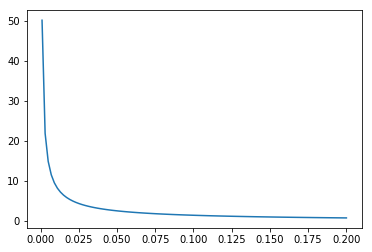

In [0]:
#First customer will follow Gamma(gamma,alpha+1)

lmbda=np.linspace(0.001,0.2,100)
alpha=alpha_hat+1
gamma=gamma_hat
pdf=alpha**gamma/spsp.gamma(gamma)*lmbda**(gamma-1)*np.exp(-alpha*lmbda)
plt.plot(lmbda,pdf)
plt.show()

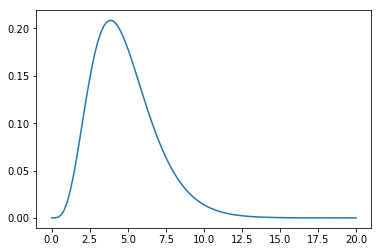

In [0]:
#Second customer will follow Gamma(gamma+10,alpha+1)

lmbda=np.linspace(0.001,20,100)
alpha=alpha_hat+1
gamma=gamma_hat+5
pdf=alpha**gamma/spsp.gamma(gamma)*lmbda**(gamma-1)*np.exp(-alpha*lmbda)
plt.plot(lmbda,pdf)
plt.show()

#Exercise 2 [Total: 37  Points]

##Setting

In this exercise, we discuss a model that deals with discrete timing. We will use sports analytics as the background for this study. The data is collected from Kaggle. [link](https://www.kaggle.com/kendallgillies/nflstatistics)

In this dataset, we have the information of all the NFL players who are both currently active and have already retired before 2018. In this question, we are interested in modeling the number of years they were active before they retire. 


In [0]:
#Load the dataset
link="https://drive.google.com/open?id=1voxCbS9xGieGHiEYYCzK61f4BZQWy6SD"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NFL.csv')  
NFL = pd.read_csv('NFL.csv')
NFL.head(5)



,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
0,NaN,"Grand Rapids , MI",5/23/1921,Notre Dame,Retired,NaN,3 Seasons,71.0,NaN,NaN,"Evans, Fred",NaN,fredevans/2513736,NaN,185.0,1946 - 1948
1,NaN,"Dayton , OH",12/21/1930,Dayton,Retired,NaN,1 Season,70.0,NaN,NaN,"Raiff, Jim",NaN,jimraiff/2523700,NaN,235.0,1954 - 1954
2,56.0,"Temple , TX",9/11/1960,Louisiana Tech,Retired,NaN,1 Season,74.0,NaN,NaN,"Fowler, Bobby",NaN,bobbyfowler/2514295,NaN,230.0,1985 - 1985
3,30.0,"New Orleans , LA",9/30/1986,LSU,Retired,NaN,5 Seasons,73.0,NaN,NaN,"Johnson, Quinn",NaN,quinnjohnson/79593,NaN,255.0,2009 - 2013
4,25.0,"Detroit , MI",3/31/1992,Central Michigan,Active,Pittsburgh Steelers,3rd season,77.0,Clintondale HS,"Clinton Twp.,Macomb Co., MI","Walton, L.T.",96.0,l.t.walton/2552444,DE,305.0,NaN


##Q1 [3 points]
**[data cleaning]**

We will clean our data using the following steps:
* **Keep only retired players**  
* Compute the number of active years for each player based on the last column. For example, if "Year Played" for a player is 1954-1954, the number of active years will be 0, while if  "Year Played" for a player is 1971 to 1974, the number of active years will be 3. You will find  [str.split()](https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/) function useful for this question.

In [0]:
NFL=NFL[NFL["Current Status"]=="Retired"]
Processed=NFL["Years Played"].str.split("-",expand=True)
Processed=Processed.astype({0:"int64",1:"int64"}) 
y=(Processed[1]-Processed[0]).values
y
 

array([2, 0, 0, ..., 0, 1, 0], dtype=int64)

In [0]:
NFL=NFL.assign(Years=y)
NFL.groupby("Years").count()

,Age,Birth Place,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Name,Number,Player Id,Position,Weight (lbs),Years Played
Years,,,,,,,,,,,,,,,,
0,3282,3388,4564,4675,4709,0,4675,4594,0,0,4709,0,4709,0,4665,4709
1,1379,1613,1879,1895,1897,0,1895,1883,0,0,1897,0,1897,0,1894,1897
2,995,1192,1286,1298,1300,0,1298,1291,0,0,1300,0,1300,0,1298,1300
3,907,1124,1164,1172,1173,0,1172,1168,0,0,1173,0,1173,0,1172,1173
4,703,894,904,909,909,0,909,907,0,0,909,0,909,0,909,909
5,614,769,776,783,783,0,783,782,0,0,783,0,783,0,783,783
6,545,699,701,702,702,0,702,702,0,0,702,0,702,0,702,702
7,463,588,588,588,588,0,588,588,0,0,588,0,588,0,587,588
8,423,528,528,529,529,0,529,529,0,0,529,0,529,0,529,529


##Q2 [10 points]

**[Application of One-segment model]**

Let's think about what distribution would fit this variable. One assumption we can make is that for each year, there is a probability $\theta$ for this person to retire, probability $1-\theta$ for this person to active. We also assume that the years are independent from one another. We are interested in examining the number of years $y$ it takes for retirement to happen. This is modeled by a [Geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution), which is defined as the distribution that measures the number of failuress ($y$) it takes before the first success happens when each trial are indepedently and identically distribution with probability of suceess equals $\theta$.

For a Geometric model, 

$P(y)=(1-\theta)^y \theta$ for  $y=0, 1, 2, ...$,

here $0\leq \theta \leq 1$.

$E(y)=\frac{1-\theta}{\theta}$

* Estimate $\hat{\theta}$ for this model  
* What is the expected number of years for a NFL player to be active?
* What is the probability for a player to serve for 4 years?
* Now do a visualization to check the model performance. In this graph

>> Visualize the observed number of players served 0 years, 1 years... using a bar chart 

>> Based on the model, predict the number of players served 0 years, 1 years, ... Visualize in the same graph as well using a scatter plot. 

In [0]:
def neg_LL(betas):
  theta=np.exp(betas[0])/(1+np.exp(betas[0]))
  ind_L=(1-theta)**y*theta
  return -np.sum(np.log(ind_L))

model1=minimize(neg_LL,np.random.rand(1),method="BFGS")
print(model1.x)
print(model1.fun)


[-1.14921862]
32278.510531268366


In [0]:
betas=model1.x
theta_hat= np.exp(betas[0])/(1+np.exp(betas[0]))
theta_hat

0.24063183380446332

In [0]:
#expected number of years
(1-theta_hat)/theta_hat

3.1557261322813877

In [0]:
#prob to server for 4 years

(1-theta_hat)**4*theta_hat

0.08001338217687433

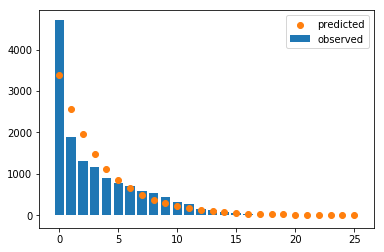

In [0]:
#Visualization
#compute the observed number of visitors having 0, 1, 2,... fish.
outcomes, counts=np.unique(y,return_counts=True)
#visualization
plt.bar(outcomes, counts,label="observed")
x=np.arange(0,np.max(outcomes)+1)
prediction=(1-theta_hat)**x*theta_hat*len(y)
plt.scatter(x,prediction,zorder=2,label="predicted")
plt.legend(loc="best")
plt.show()

##Q3 [10 points]
###[Estimating a two-segment model]

The previous model assumes that all the players have the same $\theta$, which might be a flawed assumption. Instead, we might want to model two segment of players: one segment players have high risk of retiring (high $\theta$), while the other segment of players have lower risk of retiring (low $\theta$)

* Use a two-segment model to identify $\theta_1$, $\theta_2$, and $p$
* Interpret what these three estimated parameters mean.
* For each segment, what is the expected number of years for a player to remain active?
* If we observed a player retired after 3 years of playing, what is the probability for this player to belong to the low risk group?
* Plot the observed v.s. predicted numbers like you did in Q1. Comment on any changes in the model fitting.
 

In [0]:
def neg_LL(betas):
  theta1=np.exp(betas[0])/(1+np.exp(betas[0]))
  theta2=np.exp(betas[1])/(1+np.exp(betas[1]))
  p=np.exp(betas[2])/(1+np.exp(betas[2]))
  ind_L1=(1-theta1)**y*theta1
  ind_L2=(1-theta2)**y*theta2
  ind_L=ind_L1*p+ind_L2*(1-p)
  return -np.sum(np.log(ind_L))

model2=minimize(neg_LL,np.random.rand(3),method="BFGS")
print(model2.x)
print(model2.fun)


[24.39198701 -1.31966837 -1.68287976]
31852.5711428258


In [0]:
betas=model2.x
theta1_hat= np.exp(betas[0])/(1+np.exp(betas[0]))
theta2_hat= np.exp(betas[1])/(1+np.exp(betas[1]))
p_hat= np.exp(betas[2])/(1+np.exp(betas[2]))
print(theta1_hat,theta2_hat,p_hat)

0.999999999974491 0.21087347356653524 0.15671451757832416


The probability for a player to retire in each year is 0.21 if a player belongs to the second segment.
A player will retire in the first year if a player belongs to the first  segment. The probability for a player to belong to the first segment is 0.157.


In [0]:
#Since this player served for 4 years, it must mean he belongs to the second group.
#Because if he belongs to the first group, there is zero chances that he servers for 
#more than 1 year. 

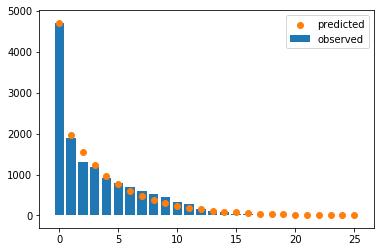

In [0]:
#Visualization
#compute the observed number of visitors having 0, 1, 2,... fish.
outcomes, counts=np.unique(y,return_counts=True)
#visualization
plt.bar(outcomes, counts,label="observed")
x=np.arange(0,np.max(outcomes)+1)
PMF1=(1-theta1_hat)**x*theta1_hat
PMF2=(1-theta2_hat)**x*theta2_hat
PMF=PMF1*p_hat+PMF2*(1-p_hat)
prediction=PMF*len(y)
plt.scatter(x,prediction,zorder=2,label="predicted")
plt.legend(loc="best")
plt.show()

The model fitting becomes much better than 1 segment model.

##Q4 [4 points]

Now, we move on to assume that $\theta$ follows a continuous distribution. It is often assume that $\theta$ follows a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with $\theta \sim Beta(\alpha, \beta)$, which has the following pdf:

$f(\theta)=\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha,\beta)}= \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}}$

Here, you can either use spsp.gamma to compute $B(\alpha,\beta)$. You can also simply use spsp.beta(alpha,beta) to compute $B(\alpha,\beta)$ directly.

where $\alpha$ and $\beta$ are both positive, $0<\theta<1$. In addition, $E(\theta)=\frac{\alpha}{\alpha+\beta}$

Reproduce the following probability density function  [The color of the lines does not matter]

https://pythonforundergradengineers.com/unicode-characters-in-python.html
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/650px-Beta_distribution_pdf.svg.png
" width="450"/>
</div>



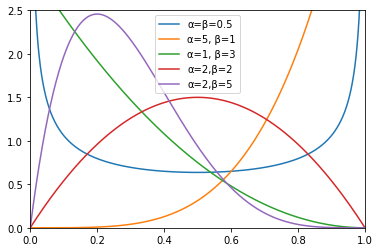

In [0]:
def beta_pdf(alpha,beta):
  return x**(alpha-1)*(1-x)**(beta-1)/spsp.beta(alpha,beta)

x=np.linspace(0.00001,1-0.00001,1000)
plt.plot(x,beta_pdf(0.5,0.5),label="\u03B1=\u03B2=0.5")
plt.plot(x,beta_pdf(5,1),label="\u03B1=5, \u03B2=1")
plt.plot(x,beta_pdf(1,3),label="\u03B1=1, \u03B2=3")
plt.plot(x,beta_pdf(2,2),label="\u03B1=2,\u03B2=2")
plt.plot(x,beta_pdf(2,5),label="\u03B1=2,\u03B2=5")
plt.ylim(bottom=0,top=2.5)
plt.xlim(left=0,right=1)

plt.legend(loc="best")
plt.show()




##Q5. [6 points]

It can be proved that the probability of P(x) when assuming $\theta \sim Beta(\alpha, \beta)$ will following PMF.

$P(x)=\frac{B(\alpha+1,x+\beta)}{B(\alpha,\beta)}$

* Estimate $\alpha$ and $\beta$.
* What is the probability for a player to serve for 4 years? 
* Plot the observed v.s. predicted numbers like you did in Q1. Comment on any changes in the model fitting.

In [0]:
def neg_LL(betas):
  alpha=np.exp(betas[0]) 
  beta=np.exp(betas[1]) 
  ind_L=spsp.beta(alpha+1,y+beta)/spsp.beta(alpha,beta)
  return -np.sum(np.log(ind_L))

model3=minimize(neg_LL,np.random.rand(2),method="BFGS")
print(model3.x)
print(model3.fun)


[4.9465378  6.08870739]
32278.56103692804


In [0]:
betas=model3.x
alpha_hat=np.exp(betas[0]) 
beta_hat=np.exp(betas[1])

alpha_hat/(alpha_hat+beta_hat)

0.2419222436350367

In [0]:
#probability to serve for 4 years
spsp.beta(alpha_hat+1,4+beta_hat)/spsp.beta(alpha_hat,beta_hat)

0.07961174756783732

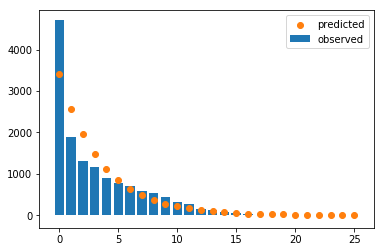

In [0]:
#Visualization
#compute the observed number of visitors having 0, 1, 2,... fish.
outcomes, counts=np.unique(y,return_counts=True)
#visualization
plt.bar(outcomes, counts,label="observed")
x=np.arange(0,np.max(outcomes)+1)
PMF=spsp.beta(alpha_hat+1,x+beta_hat)/spsp.beta(alpha_hat,beta_hat)
prediction=PMF*len(y)
plt.scatter(x,prediction,zorder=2,label="predicted")
plt.legend(loc="best")
plt.show()

The model fit looks very similar to a one-segment model.

##Q6. [4 points]

It can be proved that the posterior of $\theta|x$ still follows a Beta distribution

$\theta|x \sim Beta(\alpha+1,\beta+x)$

* Based on the estimated model, plot the distribution of $\theta$ given x=0. 
* In the same graph, plot the distribution of $\theta$ when x=10.
* Add a legend to the plot.

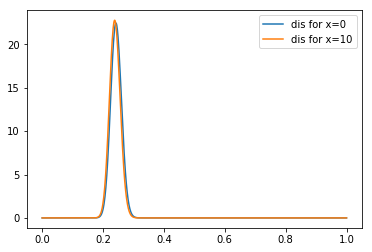

In [0]:
def beta_pdf(alpha,beta):
  return x**(alpha-1)*(1-x)**(beta-1)/spsp.beta(alpha,beta)

x=np.linspace(0.00001,1-0.00001,1000)
plt.plot(x,beta_pdf(alpha_hat+1,beta_hat+0),label="dis for x=0")
plt.plot(x,beta_pdf(alpha_hat+1,beta_hat+10),label="dis for x=10")
plt.legend(loc="best")
plt.show()


